In [26]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#import torchvision.transforms as T
from collections import namedtuple, deque
import Environments
from collections import OrderedDict

In [27]:
     
class ActionNoise:
    def __init__(self, mean, std_deviation,total_episodes):
        self.mean = mean
        self.std_dev = std_deviation
        self.change_ep = std_deviation/(total_episodes)
    def __call__(self,size):
        return torch.normal(torch.tensor(self.mean).repeat(size),torch.tensor(self.std_dev).repeat(size))
    def change_std(self):
        self.std_dev=max(self.std_dev-self.change_ep,0.05)
    
Transition = namedtuple('Transition',('state', 'action', 'reward', 'next_state','done'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def size(self):
        a=random.sample(self.memory, batch_size)
        return a.size
    
    def __len__(self):
        return len(self.memory)



In [28]:
def soft_update(target, source, tau):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)
        
def hard_update(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)

class DDPG_actor2(nn.Module):

    def __init__(self, np_inputs, nb_outputs, model):
        super(DDPG_actor2, self).__init__()  
        self.layer1=nn.Linear(np_inputs, 64)
        self.layer2=nn.Linear(64, 64)
        self.layer3=nn.Linear(64, nb_outputs)
        
        self.ln1 = nn.LayerNorm(64)
        self.ln2 = nn.LayerNorm(64)
        #self.Tanh=nn.Tanh()
        torch.nn.init.uniform_(self.layer3.weight,-0.003, 0.003)
        
    def forward(self, input1):
        if isinstance(input1, np.ndarray):
            input1 = torch.tensor(input1, dtype=torch.float)
        output=F.relu(self.ln1(self.layer1(input1)))
        output=F.relu(self.ln2(self.layer2(output)))
        output=torch.tanh(self.layer3(output))
        return output
    
class DDPG_critic2(nn.Module):
    def __init__(self, nb_input1, nb_input2, nb_outputs, model):
        super(DDPG_critic2, self).__init__()  
        self.state_net1=nn.Linear(nb_input1, 48)
        self.state_net2=nn.Linear(48, 48)
        self.action_net1=nn.Linear(nb_input2, 48)
        self.merge_net1=nn.Linear(96, 48)
        self.merge_net2=nn.Linear(48, nb_outputs)
        self.ln1 = nn.LayerNorm(48)
        self.ln2 = nn.LayerNorm(48)
        self.ln3 = nn.LayerNorm(48)
        self.ln4 = nn.LayerNorm(48)
        torch.nn.init.uniform_(self.merge_net2.weight,-0.003, 0.003)

    def forward(self, input1, input2):
        if isinstance(input1, np.ndarray):
            input1 = torch.tensor(input1, dtype=torch.float)
        if isinstance(input2, np.ndarray):
            input2 = torch.tensor(input2, dtype=torch.float)
            
        output1=F.relu(self.ln1(self.state_net1(input1)))
        output1=F.relu(self.ln2(self.state_net2(output1)))
        output2=F.relu(self.ln3(self.action_net1(input2)))
        output3=torch.cat((output1,output2),dim=1)
        output_final=F.relu(self.ln4(self.merge_net1(output3)))
        output_final=self.merge_net2(output_final)
        return output_final

    
class DDPG_actor(nn.Module):
    def __init__(self, np_inputs, nb_outputs, model):
        super(DDPG_actor, self).__init__()  
        self.layer1=nn.Linear(np_inputs, 64)
        self.layer2=nn.Linear(64, 64)
        self.layer3=nn.Linear(64, nb_outputs)
        #self.Tanh=nn.Tanh()
        torch.nn.init.uniform_(self.layer3.weight,-0.003, 0.003)
        
    def forward(self, input1):
        if isinstance(input1, np.ndarray):
            input1 = torch.tensor(input1, dtype=torch.float)
        output=F.relu(self.layer1(input1))
        output=F.relu(self.layer2(output))
        output=torch.tanh(self.layer3(output))
        return output
    
class DDPG_critic(nn.Module):
    def __init__(self, nb_input1, nb_input2, nb_outputs, model):
        super(DDPG_critic, self).__init__()  
        self.state_net1=nn.Linear(nb_input1, 48)
        self.state_net2=nn.Linear(48, 48)
        self.action_net1=nn.Linear(nb_input2, 48)
        self.merge_net1=nn.Linear(96, 48)
        self.merge_net2=nn.Linear(48, nb_outputs)
        torch.nn.init.uniform_(self.merge_net2.weight,-0.003, 0.003)

    def forward(self, input1, input2):
        if isinstance(input1, np.ndarray):
            input1 = torch.tensor(input1, dtype=torch.float)
        if isinstance(input2, np.ndarray):
            input2 = torch.tensor(input2, dtype=torch.float)
            
        output1=F.relu(self.state_net1(input1))
        output1=F.relu(self.state_net2(output1))
        output2=F.relu(self.action_net1(input2))
        output3=torch.cat((output1,output2),dim=1)
        output_final=F.relu(self.merge_net1(output3))
        output_final=self.merge_net2(output_final)
        return output_final

In [29]:
# Itération sur l'environnement :
class Env_rollout:
    """ 
    Itération sur l'environnement pour la current policy.
    
    :param env: environnement choisi
    :param max_steps: nombre de steps maximal pour un épisode
    """
    def __init__(self, env, max_steps):
        self.env = env
        self.max_steps = max_steps
        self.prev_state = env.reset()
        
    def select_action(self, actor_net, state, noise):
        actor_net.eval()
        action=torch.squeeze(actor_net(torch.unsqueeze(torch.tensor(state), dim=0)))
        actor_net.train()
        if(action.dim()==0):
            action=torch.unsqueeze(action,dim=0)
        if(noise is not None):
            action=action+noise(1)
        legal_action=torch.clamp(action, min=-1e0, max=1e0)
        return action, legal_action
    
    def iterations(self,actor_net, nbr_episodes):
        """
        Roll Out: on visite l'environnement sur un nombre de steps donné.
        :param actor_net: Politique appliquée à l'environnement
        :param nbr_episodes: Nombre d'épisodes
        :return: Tensors; batch des états, des actions, des rewards
        """
        batch_obs=[]
        batch_acts=[]
        batch_rews=[]
        for ep in range(nbr_episodes):
            prev_state = env.reset()
            for step_ep in range(self.max_steps): 
                with torch.no_grad():
                    action, legal_action = self.select_action(actor_net, prev_state, None)
                    state, reward, done, _ = self.env.step(legal_action.detach().numpy())
                    batch_obs.append(prev_state)
                    batch_acts.append(legal_action.detach().numpy())
                    batch_rews.append(reward)
                    prev_state = state
                if done:
                    break
        return torch.tensor(batch_obs, dtype=torch.float), torch.tensor(batch_acts, dtype=torch.float), torch.tensor(batch_rews, dtype=torch.float)



In [33]:
class Algo_DDPG():
    """ 
    Algorithme du PPO : apprentissage et tests.
    :param policy_class_a: politique (actor model)
    :param policy_class_c: politique (critic model)
    :param env: environnement choisi
    :param hyperparameters: hyperparamètres flottants ou entiers du modèle
    """
    def __init__(self, policy_class_a, policy_class_c, env, **hyperparameters):
        
        self._init_hyperparameters(hyperparameters)
        self.actor_net = policy_class_a(num_states, num_actions, "online")
        self.critic_net = policy_class_c(num_states, num_actions, 1, "online")
        self.target_actor_net = policy_class_a(num_states, num_actions, "target")
        self.target_critic_net = policy_class_c(num_states, num_actions, 1, "target")
        hard_update(self.target_critic_net,self.critic_net)
        hard_update(self.target_actor_net,self.actor_net)
        self.optimizer_critic = optim.Adam(self.critic_net.parameters(), self.critic_lr,weight_decay=0.01)
        self.optimizer_actor = optim.Adam(self.actor_net.parameters(), self.actor_lr)
        self.rollout = Env_rollout(env, self.max_steps)
    
    def evaluate(self, nbr_episodes, selection):
        """
        Evaluation du modèle
        :param nbr_episodes: nombre d'épisodes 
        """
        if(selection=="target"):
            state_batch, action_batch, rewards_batch = self.rollout.iterations(self.target_actor_net, nbr_episodes)
        else:
            state_batch, action_batch, rewards_batch = self.rollout.iterations(self.actor_net, nbr_episodes)
        return state_batch, action_batch, rewards_batch
    
    def optimize_model(self):
        """
        Optimisation du modèle
        """
        if len(self.memory) < self.batch_size:
            return
        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))
        criterion=nn.MSELoss(reduction='mean')

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        next_state_batch = torch.cat(batch.next_state)
        done_batch = torch.cat(batch.done)
        #Critic optimization
        self.optimizer_critic.zero_grad()
        target_actor_batch = self.target_actor_net.forward(next_state_batch)
        target_critic_batch = self.target_critic_net.forward(next_state_batch,target_actor_batch.detach())
        critic_action_batch = self.critic_net.forward(state_batch,action_batch)
        expected_state_action_values = (torch.mul(target_critic_batch, torch.unsqueeze(done_batch,dim=1)) * self.gamma) + reward_batch
        critic_loss = criterion(expected_state_action_values.detach(),critic_action_batch)
        critic_loss.backward()
        self.optimizer_critic.step()

        #Actor optimization
        self.optimizer_actor.zero_grad()
        actor_batch = self.actor_net.forward(state_batch)
        critic_actor_batch = self.critic_net.forward(state_batch,actor_batch)
        actor_loss = - critic_actor_batch.mean()
        actor_loss.backward()
        self.optimizer_actor.step()
        return reward_batch
    
    def select_action(self, actor_net, state, noise):
        actor_net.eval()
        action=torch.squeeze(actor_net(torch.unsqueeze(torch.tensor(state), dim=0)))
        actor_net.train()
        if(action.dim()==0):
            action=torch.unsqueeze(action,dim=0)
        if(noise is not None):
            action=action+noise(1)
        legal_action=torch.clamp(action, min=-1e0, max=1e0)
        return action, legal_action
    
    def train(self, nb_loop):
        """
        Apprentissage des réseaux. 
        :param nb_loop: nombre de loops 
        """
        self.noise = ActionNoise(self.mean_dev, self.std_dev, nb_loop)
        for i in range(10):
            prev_state = env.reset()
            #episodic_reward = torch.tensor([0.0], device=device).float()
            for step_ep in range(self.max_steps):
                action, legal_action = self.select_action(self.actor_net, prev_state, self.noise)
                state, reward, done, _ = env.step(legal_action.detach().numpy())
                episodic_reward = torch.tensor([reward], device=device)#+episodic_reward
                self.memory.push(torch.unsqueeze(torch.tensor(prev_state), dim=0),
                                 torch.unsqueeze(action.detach(), dim=0).float(),
                                 torch.unsqueeze(episodic_reward, dim=0).float(),
                                 torch.unsqueeze(torch.tensor(state), dim=0).float(),
                                 torch.unsqueeze(torch.tensor(done), dim=0))
                if done:
                    break
        n_step=0
        while n_step<nb_loop:
            prev_state = env.reset()
            #episodic_reward = torch.tensor([0.0], device=device).float()
            for step_ep in range(self.max_steps):
                action, legal_action = self.select_action(self.actor_net, prev_state, self.noise)
                state, reward, done, _ = env.step(legal_action.detach().numpy())
                episodic_reward = torch.tensor([reward], device=device)#+episodic_reward
                self.memory.push(torch.unsqueeze(torch.tensor(prev_state), dim=0),
                                 torch.unsqueeze(action.detach(), dim=0).float(),
                                 torch.unsqueeze(episodic_reward, dim=0).float(),
                                 torch.unsqueeze(torch.tensor(state), dim=0).float(),
                                 torch.unsqueeze(torch.tensor(done), dim=0)
                                )
                prev_state = state
                n_step=n_step+1
                if (n_step%10==0):
                    batch_rew2=self.optimize_model()
                    soft_update(self.target_critic_net,self.critic_net,self.tau)
                    soft_update(self.target_actor_net,self.actor_net,self.tau)
                    if(batch_rew2 != None):
                        self.ep_reward_list.append(batch_rew2.mean().detach().numpy())
                if done:
                    break
            if(len(self.ep_reward_list)>0):
                avg_reward = np.mean(self.ep_reward_list[-30:])
                print("Steps * {} * Avg Reward is ==> {}".format(n_step, avg_reward))
            self.total_loop= self.total_loop +1
            self.noise.change_std()
        path='load_model/parameters/ddpg4-{num_algo:02d}-{name}-{epoch:02d}00.npy'
        with open(path.format(num_algo=self.num_algo,epoch=int(self.total_loop/1000),name="reward"), 'wb') as f:
            np.save(f, np.array(self.ep_reward_list))
        print("Complete")
        
    def _init_hyperparameters(self, hyperparameters):
        """
        Initialisation des hyperparamètres.
        :param hyperparameters: hyperparamètres flottants ou entiers du modèle
        """
        self.num_algo = 1
        self.batch_size = 64
        self.memory = ReplayMemory(100000)
        self.tau = 0.005
        self.gamma = 0.99
        self.mean_dev = 0.0
        self.std_dev = 0.5
        self.max_steps = 90
        self.total_loop = 0
        self.critic_lr = 3e-3
        self.actor_lr = 3e-4
        self.ep_reward_list=[]
        for param, val in hyperparameters.items():
            exec('self.' + param + ' = ' + str(val)) #juste trop fort
            
    def loading(self, num_algo, total_loop):
        self.num_algo = num_algo
        self.total_loop = total_loop
        checkpoint_path1 = "load_model/weights/torch-ddpg4-{num_algo:02d}-actor-{epoch:03d}000.pth"
        self.actor_net.load_state_dict(torch.load(checkpoint_path1.format(epoch=int(self.total_loop/1000), num_algo=self.num_algo)))
        checkpoint_path2 = "load_model/weights/torch-ddpg4-{num_algo:02d}-critic-{epoch:03d}000.pth"
        self.critic_net.load_state_dict(torch.load(checkpoint_path2.format(epoch=int(self.total_loop/1000), num_algo=self.num_algo)))
    
    def saving(self):
        checkpoint_path = "load_model/weights/torch-ddpg4-{num_algo:02d}-actor-{epoch:03d}000.pth"
        torch.save(self.actor_net.state_dict(),checkpoint_path.format(epoch=int(self.total_loop/1000), num_algo=self.num_algo))
        checkpoint_path = "load_model/weights/torch-ddpg4-{num_algo:02d}-critic-{epoch:03d}000.pth"
        torch.save(self.critic_net.state_dict(),checkpoint_path.format(epoch=int(self.total_loop/1000), num_algo=self.num_algo)) 



In [34]:
# Importation du premier environnement
problem = "Crossway_comparison-v0"
u_b = [2.0, 11.0, -12.5, 1.1, -1.0]
l_b = [-4.0, 9.0, -32.5, 0.9, -2.0]

env = gym.make(problem,dt=0.3,Vm=2.5,tau=1.0,lower_bounds=l_b, upper_bounds=u_b,simulation="sin")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_states = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
num_algo=50

algo=Algo_DDPG(DDPG_actor, DDPG_critic, env, num_algo= num_algo, num_states=num_states, num_actions=num_actions)
#algo.loading(34,52000)

In [ ]:
#Training
algo.train(2000000)
algo.saving()

Accident!
Accident!
Accident!
Steps * 34 * Avg Reward is ==> -16.70332908630371
Steps * 66 * Avg Reward is ==> -15.24661922454834
Steps * 96 * Avg Reward is ==> -15.068411827087402
Steps * 119 * Avg Reward is ==> -14.470596313476562
Steps * 145 * Avg Reward is ==> -13.961090087890625
Steps * 180 * Avg Reward is ==> -13.383295059204102
Steps * 205 * Avg Reward is ==> -13.787446975708008
Steps * 228 * Avg Reward is ==> -13.502203941345215
Steps * 254 * Avg Reward is ==> -13.310882568359375
Steps * 283 * Avg Reward is ==> -13.03026294708252
Steps * 307 * Avg Reward is ==> -13.167719841003418
Steps * 334 * Avg Reward is ==> -12.816385269165039
Steps * 365 * Avg Reward is ==> -12.604705810546875
Steps * 391 * Avg Reward is ==> -12.224699974060059
Steps * 423 * Avg Reward is ==> -12.32193660736084
Steps * 447 * Avg Reward is ==> -12.10220718383789
Steps * 469 * Avg Reward is ==> -12.45650577545166
Steps * 497 * Avg Reward is ==> -12.303644180297852
Steps * 519 * Avg Reward is ==> -12.3210315

Steps * 4512 * Avg Reward is ==> -8.503862380981445
Steps * 4540 * Avg Reward is ==> -8.627382278442383
Steps * 4570 * Avg Reward is ==> -8.656916618347168
Steps * 4593 * Avg Reward is ==> -8.38869571685791
Steps * 4620 * Avg Reward is ==> -8.130098342895508
Steps * 4645 * Avg Reward is ==> -8.016654014587402
Steps * 4672 * Avg Reward is ==> -8.004132270812988
Steps * 4711 * Avg Reward is ==> -7.994817733764648
Steps * 4739 * Avg Reward is ==> -8.319743156433105
Steps * 4768 * Avg Reward is ==> -8.613635063171387
Steps * 4794 * Avg Reward is ==> -8.73231315612793
Steps * 4818 * Avg Reward is ==> -8.796361923217773
Steps * 4850 * Avg Reward is ==> -8.691819190979004
Steps * 4878 * Avg Reward is ==> -8.524539947509766
Steps * 4906 * Avg Reward is ==> -8.631586074829102
Steps * 4932 * Avg Reward is ==> -8.535226821899414
Steps * 4965 * Avg Reward is ==> -8.603455543518066
Steps * 4986 * Avg Reward is ==> -8.644856452941895
Steps * 5008 * Avg Reward is ==> -8.67412281036377
Steps * 5033 * 

Steps * 9026 * Avg Reward is ==> -6.909745216369629
Steps * 9053 * Avg Reward is ==> -6.89215612411499
Steps * 9080 * Avg Reward is ==> -6.871922016143799
Steps * 9106 * Avg Reward is ==> -6.915497779846191
Steps * 9138 * Avg Reward is ==> -6.915696620941162
Steps * 9228 * Avg Reward is ==> -6.564334392547607
Steps * 9257 * Avg Reward is ==> -6.4987382888793945
Steps * 9280 * Avg Reward is ==> -6.7294392585754395
Steps * 9307 * Avg Reward is ==> -6.70932674407959
Steps * 9335 * Avg Reward is ==> -6.80791711807251
Steps * 9359 * Avg Reward is ==> -6.794838905334473
Steps * 9385 * Avg Reward is ==> -6.842016696929932
Steps * 9409 * Avg Reward is ==> -6.751007556915283
Steps * 9447 * Avg Reward is ==> -6.7206878662109375
Steps * 9537 * Avg Reward is ==> -6.7846174240112305
Steps * 9561 * Avg Reward is ==> -7.039015293121338
Steps * 9589 * Avg Reward is ==> -6.902721881866455
Steps * 9620 * Avg Reward is ==> -6.9777984619140625
Steps * 9649 * Avg Reward is ==> -6.96585750579834
Steps * 967

Steps * 14567 * Avg Reward is ==> -7.290212154388428
Steps * 14595 * Avg Reward is ==> -7.350911617279053
Steps * 14629 * Avg Reward is ==> -7.263753890991211
Steps * 14660 * Avg Reward is ==> -7.258575916290283
Steps * 14692 * Avg Reward is ==> -7.361046314239502
Steps * 14722 * Avg Reward is ==> -7.582197189331055
Steps * 14746 * Avg Reward is ==> -7.547232627868652
Steps * 14769 * Avg Reward is ==> -7.694839000701904
Steps * 14795 * Avg Reward is ==> -7.7445807456970215
Steps * 14828 * Avg Reward is ==> -7.679288387298584
Steps * 14861 * Avg Reward is ==> -7.776318073272705
Steps * 14894 * Avg Reward is ==> -7.737607479095459
Steps * 14920 * Avg Reward is ==> -7.75410270690918
Steps * 14958 * Avg Reward is ==> -7.696737289428711
Steps * 14982 * Avg Reward is ==> -7.826662063598633
Steps * 15020 * Avg Reward is ==> -7.551441669464111
Steps * 15046 * Avg Reward is ==> -7.551890850067139
Steps * 15115 * Avg Reward is ==> -7.38503885269165
Accident!
Steps * 15156 * Avg Reward is ==> -7.

Steps * 20081 * Avg Reward is ==> -7.183804035186768
Steps * 20103 * Avg Reward is ==> -7.336782932281494
Steps * 20130 * Avg Reward is ==> -7.347631931304932
Steps * 20160 * Avg Reward is ==> -6.9984049797058105
Steps * 20197 * Avg Reward is ==> -6.928528308868408
Steps * 20222 * Avg Reward is ==> -6.991588115692139
Steps * 20247 * Avg Reward is ==> -6.853958606719971
Steps * 20278 * Avg Reward is ==> -6.803516864776611
Steps * 20316 * Avg Reward is ==> -6.669266223907471
Steps * 20348 * Avg Reward is ==> -6.731137275695801
Steps * 20371 * Avg Reward is ==> -6.6708855628967285
Steps * 20397 * Avg Reward is ==> -6.657303333282471
Steps * 20419 * Avg Reward is ==> -6.456171989440918
Steps * 20459 * Avg Reward is ==> -6.599243640899658
Steps * 20487 * Avg Reward is ==> -6.724372386932373
Steps * 20508 * Avg Reward is ==> -6.873709201812744
Steps * 20533 * Avg Reward is ==> -6.953221321105957
Steps * 20570 * Avg Reward is ==> -7.086907386779785
Steps * 20595 * Avg Reward is ==> -7.0577578

Accident!
Steps * 26314 * Avg Reward is ==> -7.370843887329102
Steps * 26337 * Avg Reward is ==> -7.32008695602417
Steps * 26361 * Avg Reward is ==> -7.503048419952393
Steps * 26387 * Avg Reward is ==> -7.552206516265869
Steps * 26424 * Avg Reward is ==> -7.489748001098633
Steps * 26467 * Avg Reward is ==> -7.536895275115967
Steps * 26490 * Avg Reward is ==> -7.518592834472656
Steps * 26532 * Avg Reward is ==> -7.458767414093018
Steps * 26558 * Avg Reward is ==> -7.423336982727051
Steps * 26610 * Avg Reward is ==> -7.15669584274292
Steps * 26631 * Avg Reward is ==> -7.292750835418701
Steps * 26654 * Avg Reward is ==> -7.135707378387451
Steps * 26700 * Avg Reward is ==> -7.022118091583252
Steps * 26736 * Avg Reward is ==> -7.089288711547852
Steps * 26781 * Avg Reward is ==> -6.904637813568115
Steps * 26817 * Avg Reward is ==> -6.909849166870117
Steps * 26877 * Avg Reward is ==> -7.003259658813477
Steps * 26902 * Avg Reward is ==> -7.083353519439697
Steps * 26931 * Avg Reward is ==> -7.0

Steps * 32303 * Avg Reward is ==> -7.001877784729004
Accident!
Steps * 32354 * Avg Reward is ==> -7.050893306732178
Steps * 32392 * Avg Reward is ==> -7.080485820770264
Steps * 32416 * Avg Reward is ==> -7.132777214050293
Steps * 32484 * Avg Reward is ==> -7.140512943267822
Steps * 32521 * Avg Reward is ==> -7.127659797668457
Steps * 32560 * Avg Reward is ==> -7.379732131958008
Steps * 32587 * Avg Reward is ==> -7.388921737670898
Steps * 32614 * Avg Reward is ==> -7.203275680541992
Accident!
Steps * 32676 * Avg Reward is ==> -7.00106954574585
Steps * 32730 * Avg Reward is ==> -6.913843154907227
Steps * 32752 * Avg Reward is ==> -6.8674187660217285
Steps * 32797 * Avg Reward is ==> -7.004712104797363
Steps * 32887 * Avg Reward is ==> -6.795051097869873
Steps * 32923 * Avg Reward is ==> -7.139551162719727
Steps * 32947 * Avg Reward is ==> -7.134673118591309
Steps * 33037 * Avg Reward is ==> -7.136971473693848
Steps * 33060 * Avg Reward is ==> -7.237359523773193
Steps * 33085 * Avg Reward

Steps * 38669 * Avg Reward is ==> -7.219851493835449
Steps * 38759 * Avg Reward is ==> -7.395916938781738
Steps * 38783 * Avg Reward is ==> -7.367475509643555
Steps * 38806 * Avg Reward is ==> -7.281886100769043
Accident!
Steps * 38856 * Avg Reward is ==> -7.396142959594727
Steps * 38934 * Avg Reward is ==> -6.990461349487305
Steps * 38972 * Avg Reward is ==> -7.028774738311768
Steps * 38997 * Avg Reward is ==> -7.044389724731445
Steps * 39024 * Avg Reward is ==> -7.143868923187256
Steps * 39079 * Avg Reward is ==> -7.131272792816162
Accident!
Steps * 39121 * Avg Reward is ==> -7.0820159912109375
Steps * 39146 * Avg Reward is ==> -6.997535705566406
Steps * 39171 * Avg Reward is ==> -7.166711330413818
Steps * 39211 * Avg Reward is ==> -7.129662990570068
Steps * 39254 * Avg Reward is ==> -7.163212776184082
Steps * 39304 * Avg Reward is ==> -7.229522705078125
Steps * 39326 * Avg Reward is ==> -7.243729591369629
Steps * 39403 * Avg Reward is ==> -7.019560813903809
Steps * 39426 * Avg Rewar

Steps * 44705 * Avg Reward is ==> -7.254336833953857
Steps * 44760 * Avg Reward is ==> -6.931082248687744
Steps * 44808 * Avg Reward is ==> -7.098588943481445
Steps * 44832 * Avg Reward is ==> -7.06140661239624
Steps * 44853 * Avg Reward is ==> -7.160624980926514
Steps * 44906 * Avg Reward is ==> -6.730527877807617
Steps * 44932 * Avg Reward is ==> -6.923138618469238
Steps * 44976 * Avg Reward is ==> -6.812741756439209
Steps * 45032 * Avg Reward is ==> -7.023701190948486
Steps * 45060 * Avg Reward is ==> -7.117714881896973
Steps * 45098 * Avg Reward is ==> -7.064268112182617
Steps * 45141 * Avg Reward is ==> -7.276089191436768
Steps * 45178 * Avg Reward is ==> -7.269301414489746
Steps * 45201 * Avg Reward is ==> -7.393973350524902
Steps * 45226 * Avg Reward is ==> -7.3030924797058105
Steps * 45262 * Avg Reward is ==> -7.128555774688721
Steps * 45305 * Avg Reward is ==> -7.126386642456055
Steps * 45330 * Avg Reward is ==> -7.20782995223999
Steps * 45364 * Avg Reward is ==> -7.2069120407

Steps * 50482 * Avg Reward is ==> -6.584143161773682
Steps * 50572 * Avg Reward is ==> -6.615960597991943
Steps * 50616 * Avg Reward is ==> -6.961580753326416
Steps * 50655 * Avg Reward is ==> -7.110401630401611
Steps * 50695 * Avg Reward is ==> -6.825716018676758
Steps * 50734 * Avg Reward is ==> -7.129626750946045
Steps * 50788 * Avg Reward is ==> -7.297320365905762
Steps * 50820 * Avg Reward is ==> -7.312630653381348
Steps * 50845 * Avg Reward is ==> -7.272444725036621
Steps * 50871 * Avg Reward is ==> -7.32729434967041
Steps * 50894 * Avg Reward is ==> -7.164042949676514
Steps * 50935 * Avg Reward is ==> -7.0943522453308105
Steps * 50958 * Avg Reward is ==> -7.091660976409912
Steps * 51004 * Avg Reward is ==> -7.267647743225098
Steps * 51029 * Avg Reward is ==> -7.126383304595947
Steps * 51053 * Avg Reward is ==> -7.011590003967285
Steps * 51125 * Avg Reward is ==> -7.021088600158691
Steps * 51156 * Avg Reward is ==> -6.986221790313721
Steps * 51200 * Avg Reward is ==> -6.893296718

Steps * 56404 * Avg Reward is ==> -6.759218215942383
Steps * 56428 * Avg Reward is ==> -6.762238502502441
Steps * 56468 * Avg Reward is ==> -6.716486930847168
Steps * 56519 * Avg Reward is ==> -6.744007587432861
Steps * 56609 * Avg Reward is ==> -6.495621204376221
Steps * 56655 * Avg Reward is ==> -6.720849514007568
Steps * 56708 * Avg Reward is ==> -6.783203125
Steps * 56779 * Avg Reward is ==> -6.849410533905029
Steps * 56804 * Avg Reward is ==> -6.753817081451416
Steps * 56849 * Avg Reward is ==> -6.676862716674805
Steps * 56872 * Avg Reward is ==> -6.674191951751709
Accident!
Steps * 56915 * Avg Reward is ==> -6.661440849304199
Steps * 56944 * Avg Reward is ==> -6.69735050201416
Steps * 56988 * Avg Reward is ==> -6.730391502380371
Steps * 57012 * Avg Reward is ==> -6.660146713256836
Steps * 57058 * Avg Reward is ==> -6.626673221588135
Steps * 57083 * Avg Reward is ==> -6.628206253051758
Steps * 57158 * Avg Reward is ==> -6.908661842346191
Steps * 57180 * Avg Reward is ==> -6.953613

Steps * 62531 * Avg Reward is ==> -6.567230701446533
Steps * 62621 * Avg Reward is ==> -6.3882951736450195
Steps * 62642 * Avg Reward is ==> -6.486039638519287
Steps * 62701 * Avg Reward is ==> -6.516733169555664
Steps * 62769 * Avg Reward is ==> -6.556303024291992
Steps * 62812 * Avg Reward is ==> -6.595106601715088
Accident!
Steps * 62856 * Avg Reward is ==> -6.701051235198975
Steps * 62876 * Avg Reward is ==> -6.727082252502441
Steps * 62904 * Avg Reward is ==> -6.774202823638916
Steps * 62928 * Avg Reward is ==> -6.852459907531738
Steps * 62996 * Avg Reward is ==> -6.852318286895752
Steps * 63039 * Avg Reward is ==> -6.972912311553955
Steps * 63064 * Avg Reward is ==> -7.0661420822143555
Steps * 63086 * Avg Reward is ==> -7.007317543029785
Steps * 63156 * Avg Reward is ==> -6.883362293243408
Accident!
Steps * 63199 * Avg Reward is ==> -6.733582496643066
Accident!
Steps * 63240 * Avg Reward is ==> -6.681995868682861
Accident!
Steps * 63283 * Avg Reward is ==> -6.671929836273193
Step

Steps * 68793 * Avg Reward is ==> -6.896087646484375
Steps * 68818 * Avg Reward is ==> -6.883730888366699
Steps * 68863 * Avg Reward is ==> -6.851690292358398
Steps * 68918 * Avg Reward is ==> -6.76073694229126
Steps * 68945 * Avg Reward is ==> -6.662394046783447
Steps * 68968 * Avg Reward is ==> -6.651217460632324
Steps * 69058 * Avg Reward is ==> -6.809106826782227
Steps * 69116 * Avg Reward is ==> -6.850141525268555
Steps * 69181 * Avg Reward is ==> -6.9409074783325195
Steps * 69206 * Avg Reward is ==> -7.018704891204834
Steps * 69260 * Avg Reward is ==> -6.791703701019287
Steps * 69281 * Avg Reward is ==> -6.853036880493164
Steps * 69303 * Avg Reward is ==> -6.818987846374512
Steps * 69326 * Avg Reward is ==> -6.6283040046691895
Steps * 69348 * Avg Reward is ==> -6.729849338531494
Steps * 69376 * Avg Reward is ==> -6.748953342437744
Steps * 69428 * Avg Reward is ==> -6.829347610473633
Steps * 69476 * Avg Reward is ==> -6.749846935272217
Steps * 69540 * Avg Reward is ==> -6.73894643

Steps * 74837 * Avg Reward is ==> -6.793395042419434
Steps * 74859 * Avg Reward is ==> -6.844211101531982
Accident!
Steps * 74909 * Avg Reward is ==> -6.9076385498046875
Steps * 74948 * Avg Reward is ==> -6.803716659545898
Accident!
Steps * 75017 * Avg Reward is ==> -6.8936967849731445
Steps * 75039 * Avg Reward is ==> -6.874115943908691
Steps * 75063 * Avg Reward is ==> -6.784071445465088
Steps * 75089 * Avg Reward is ==> -6.855894565582275
Steps * 75110 * Avg Reward is ==> -6.863135814666748
Steps * 75166 * Avg Reward is ==> -6.825798034667969
Steps * 75215 * Avg Reward is ==> -6.723775386810303
Accident!
Steps * 75265 * Avg Reward is ==> -6.647817611694336
Steps * 75290 * Avg Reward is ==> -6.529804706573486
Steps * 75337 * Avg Reward is ==> -6.5839738845825195
Steps * 75425 * Avg Reward is ==> -6.838328838348389
Steps * 75486 * Avg Reward is ==> -6.9380202293396
Steps * 75548 * Avg Reward is ==> -7.132828235626221
Steps * 75575 * Avg Reward is ==> -7.105179309844971
Steps * 75599 *

Steps * 80766 * Avg Reward is ==> -6.744988441467285
Steps * 80848 * Avg Reward is ==> -6.709395408630371
Steps * 80906 * Avg Reward is ==> -6.845742225646973
Steps * 80979 * Avg Reward is ==> -7.0005059242248535
Steps * 81018 * Avg Reward is ==> -6.9677205085754395
Steps * 81052 * Avg Reward is ==> -6.7537431716918945
Steps * 81075 * Avg Reward is ==> -6.757511615753174
Accident!
Steps * 81123 * Avg Reward is ==> -6.629991054534912
Steps * 81145 * Avg Reward is ==> -6.5790114402771
Steps * 81169 * Avg Reward is ==> -6.606977462768555
Steps * 81190 * Avg Reward is ==> -6.511704921722412
Accident!
Steps * 81231 * Avg Reward is ==> -6.637431621551514
Steps * 81281 * Avg Reward is ==> -6.648165225982666
Steps * 81315 * Avg Reward is ==> -6.6721954345703125
Steps * 81340 * Avg Reward is ==> -6.67368221282959
Steps * 81380 * Avg Reward is ==> -6.747216701507568
Steps * 81462 * Avg Reward is ==> -7.12236213684082
Steps * 81485 * Avg Reward is ==> -7.136537551879883
Steps * 81519 * Avg Reward

Steps * 86812 * Avg Reward is ==> -6.549644947052002
Steps * 86873 * Avg Reward is ==> -6.617889404296875
Steps * 86921 * Avg Reward is ==> -6.7105889320373535
Accident!
Steps * 86958 * Avg Reward is ==> -6.80896520614624
Steps * 87002 * Avg Reward is ==> -6.739619255065918
Accident!
Steps * 87047 * Avg Reward is ==> -6.737485885620117
Steps * 87096 * Avg Reward is ==> -6.767734050750732
Accident!
Steps * 87135 * Avg Reward is ==> -6.727212905883789
Steps * 87167 * Avg Reward is ==> -6.755351543426514
Steps * 87222 * Avg Reward is ==> -6.864099502563477
Steps * 87246 * Avg Reward is ==> -6.773359775543213
Steps * 87271 * Avg Reward is ==> -6.746598243713379
Steps * 87292 * Avg Reward is ==> -6.790674686431885
Steps * 87382 * Avg Reward is ==> -6.679710865020752
Steps * 87442 * Avg Reward is ==> -6.817934513092041
Steps * 87468 * Avg Reward is ==> -6.765823841094971
Steps * 87496 * Avg Reward is ==> -6.748221397399902
Steps * 87586 * Avg Reward is ==> -6.419348239898682
Steps * 87623 * 

Steps * 93251 * Avg Reward is ==> -6.5915679931640625
Steps * 93276 * Avg Reward is ==> -6.6705522537231445
Steps * 93316 * Avg Reward is ==> -6.718321800231934
Steps * 93338 * Avg Reward is ==> -6.8416852951049805
Steps * 93361 * Avg Reward is ==> -6.819677352905273
Steps * 93417 * Avg Reward is ==> -7.031371116638184
Steps * 93443 * Avg Reward is ==> -7.083435535430908
Steps * 93469 * Avg Reward is ==> -7.0110578536987305
Steps * 93530 * Avg Reward is ==> -7.040576457977295
Steps * 93552 * Avg Reward is ==> -7.004672050476074
Steps * 93597 * Avg Reward is ==> -6.97227144241333
Steps * 93622 * Avg Reward is ==> -7.035420894622803
Steps * 93651 * Avg Reward is ==> -6.92050838470459
Steps * 93674 * Avg Reward is ==> -6.840461254119873
Steps * 93700 * Avg Reward is ==> -6.630621910095215
Steps * 93746 * Avg Reward is ==> -6.59391450881958
Steps * 93769 * Avg Reward is ==> -6.646769046783447
Steps * 93794 * Avg Reward is ==> -6.560563564300537
Steps * 93852 * Avg Reward is ==> -6.95440387

Steps * 99572 * Avg Reward is ==> -6.842733383178711
Steps * 99594 * Avg Reward is ==> -6.847434043884277
Accident!
Steps * 99644 * Avg Reward is ==> -6.751946926116943
Steps * 99666 * Avg Reward is ==> -6.740221977233887
Steps * 99691 * Avg Reward is ==> -6.78939151763916
Steps * 99716 * Avg Reward is ==> -6.848870277404785
Accident!
Steps * 99761 * Avg Reward is ==> -6.590473651885986
Steps * 99813 * Avg Reward is ==> -6.40994119644165
Accident!
Steps * 99851 * Avg Reward is ==> -6.584068775177002
Steps * 99876 * Avg Reward is ==> -6.707108497619629
Steps * 99898 * Avg Reward is ==> -6.7144293785095215
Accident!
Steps * 99941 * Avg Reward is ==> -6.5431389808654785
Steps * 99986 * Avg Reward is ==> -6.565783500671387
Steps * 100009 * Avg Reward is ==> -6.551339626312256
Steps * 100033 * Avg Reward is ==> -6.680903911590576
Steps * 100087 * Avg Reward is ==> -6.6984686851501465
Accident!
Steps * 100128 * Avg Reward is ==> -6.860253810882568
Steps * 100152 * Avg Reward is ==> -6.648344

Steps * 105165 * Avg Reward is ==> -6.362106800079346
Steps * 105190 * Avg Reward is ==> -6.538962364196777
Steps * 105219 * Avg Reward is ==> -6.619217395782471
Steps * 105243 * Avg Reward is ==> -6.60653018951416
Steps * 105280 * Avg Reward is ==> -6.643868923187256
Steps * 105303 * Avg Reward is ==> -6.7813005447387695
Accident!
Steps * 105345 * Avg Reward is ==> -6.687029838562012
Steps * 105410 * Avg Reward is ==> -6.671716690063477
Steps * 105433 * Avg Reward is ==> -6.652527809143066
Steps * 105456 * Avg Reward is ==> -6.584606647491455
Steps * 105500 * Avg Reward is ==> -6.53245210647583
Steps * 105523 * Avg Reward is ==> -6.489137649536133
Steps * 105545 * Avg Reward is ==> -6.539670467376709
Steps * 105570 * Avg Reward is ==> -6.619768142700195
Accident!
Steps * 105616 * Avg Reward is ==> -6.601354122161865
Steps * 105654 * Avg Reward is ==> -6.679031848907471
Steps * 105710 * Avg Reward is ==> -6.569972515106201
Steps * 105738 * Avg Reward is ==> -6.632214546203613
Steps * 1

Steps * 110814 * Avg Reward is ==> -6.6653056144714355
Steps * 110837 * Avg Reward is ==> -6.674150466918945
Steps * 110876 * Avg Reward is ==> -6.7747673988342285
Steps * 110899 * Avg Reward is ==> -6.749144077301025
Steps * 110931 * Avg Reward is ==> -6.67746114730835
Steps * 110959 * Avg Reward is ==> -6.674322605133057
Steps * 110982 * Avg Reward is ==> -6.712742328643799
Steps * 111035 * Avg Reward is ==> -6.614300727844238
Steps * 111087 * Avg Reward is ==> -6.703741550445557
Accident!
Steps * 111133 * Avg Reward is ==> -6.619388103485107
Steps * 111160 * Avg Reward is ==> -6.622615337371826
Steps * 111186 * Avg Reward is ==> -6.659379005432129
Steps * 111234 * Avg Reward is ==> -6.708085536956787
Steps * 111257 * Avg Reward is ==> -6.747923851013184
Steps * 111310 * Avg Reward is ==> -6.7472920417785645
Steps * 111363 * Avg Reward is ==> -6.583101272583008
Steps * 111388 * Avg Reward is ==> -6.561662673950195
Accident!
Steps * 111429 * Avg Reward is ==> -6.562629222869873
Steps 

Accident!
Steps * 116469 * Avg Reward is ==> -6.512951374053955
Steps * 116496 * Avg Reward is ==> -6.497837543487549
Steps * 116530 * Avg Reward is ==> -6.624337673187256
Steps * 116556 * Avg Reward is ==> -6.6134748458862305
Steps * 116579 * Avg Reward is ==> -6.5819315910339355
Steps * 116635 * Avg Reward is ==> -6.480874538421631
Steps * 116679 * Avg Reward is ==> -6.472092151641846
Accident!
Steps * 116728 * Avg Reward is ==> -6.453956127166748
Steps * 116776 * Avg Reward is ==> -6.617408275604248
Steps * 116808 * Avg Reward is ==> -6.661194324493408
Accident!
Steps * 116849 * Avg Reward is ==> -6.558070182800293
Steps * 116887 * Avg Reward is ==> -6.4796142578125
Steps * 116947 * Avg Reward is ==> -6.537953853607178
Steps * 117013 * Avg Reward is ==> -6.401706218719482
Steps * 117102 * Avg Reward is ==> -6.40774393081665
Steps * 117130 * Avg Reward is ==> -6.368117809295654
Steps * 117152 * Avg Reward is ==> -6.357661247253418
Steps * 117189 * Avg Reward is ==> -6.321624755859375

Steps * 122007 * Avg Reward is ==> -6.666231155395508
Steps * 122038 * Avg Reward is ==> -6.775622367858887
Steps * 122084 * Avg Reward is ==> -6.713733196258545
Accident!
Steps * 122130 * Avg Reward is ==> -6.710367679595947
Steps * 122169 * Avg Reward is ==> -6.7111496925354
Accident!
Steps * 122226 * Avg Reward is ==> -6.506128787994385
Steps * 122248 * Avg Reward is ==> -6.511357307434082
Steps * 122270 * Avg Reward is ==> -6.386355400085449
Steps * 122297 * Avg Reward is ==> -6.469575881958008
Steps * 122321 * Avg Reward is ==> -6.472350597381592
Steps * 122362 * Avg Reward is ==> -6.551565170288086
Accident!
Steps * 122409 * Avg Reward is ==> -6.5379638671875
Steps * 122450 * Avg Reward is ==> -6.50337553024292
Steps * 122481 * Avg Reward is ==> -6.611042499542236
Accident!
Steps * 122526 * Avg Reward is ==> -6.711690425872803
Steps * 122565 * Avg Reward is ==> -6.836491107940674
Steps * 122630 * Avg Reward is ==> -6.873002529144287
Steps * 122655 * Avg Reward is ==> -6.831212043

Accident!
Steps * 127250 * Avg Reward is ==> -6.396406173706055
Steps * 127273 * Avg Reward is ==> -6.370368957519531
Steps * 127337 * Avg Reward is ==> -6.342757225036621
Steps * 127393 * Avg Reward is ==> -6.392210006713867
Steps * 127419 * Avg Reward is ==> -6.443327903747559
Accident!
Steps * 127462 * Avg Reward is ==> -6.469329357147217
Accident!
Steps * 127507 * Avg Reward is ==> -6.546821117401123
Steps * 127532 * Avg Reward is ==> -6.462081432342529
Accident!
Steps * 127570 * Avg Reward is ==> -6.490773677825928
Steps * 127624 * Avg Reward is ==> -6.592808246612549
Steps * 127648 * Avg Reward is ==> -6.519735336303711
Accident!
Steps * 127700 * Avg Reward is ==> -6.645556449890137
Accident!
Steps * 127751 * Avg Reward is ==> -6.582616329193115
Steps * 127776 * Avg Reward is ==> -6.634984493255615
Accident!
Steps * 127822 * Avg Reward is ==> -6.6650519371032715
Steps * 127912 * Avg Reward is ==> -6.757089138031006
Accident!
Steps * 127964 * Avg Reward is ==> -6.740922451019287
S

Steps * 132948 * Avg Reward is ==> -6.547239303588867
Steps * 132998 * Avg Reward is ==> -6.447331428527832
Steps * 133020 * Avg Reward is ==> -6.428472518920898
Steps * 133044 * Avg Reward is ==> -6.363753795623779
Steps * 133067 * Avg Reward is ==> -6.445855617523193
Steps * 133089 * Avg Reward is ==> -6.4287285804748535
Accident!
Steps * 133132 * Avg Reward is ==> -6.535341739654541
Accident!
Steps * 133181 * Avg Reward is ==> -6.477044582366943
Accident!
Steps * 133222 * Avg Reward is ==> -6.524660110473633
Steps * 133278 * Avg Reward is ==> -6.682008266448975
Steps * 133305 * Avg Reward is ==> -6.705735206604004
Accident!
Steps * 133349 * Avg Reward is ==> -6.735654830932617
Steps * 133372 * Avg Reward is ==> -6.70426082611084
Steps * 133426 * Avg Reward is ==> -6.8119401931762695
Steps * 133450 * Avg Reward is ==> -6.886417865753174
Accident!
Steps * 133493 * Avg Reward is ==> -6.931993007659912
Steps * 133538 * Avg Reward is ==> -6.930245399475098
Steps * 133567 * Avg Reward is 

Steps * 138409 * Avg Reward is ==> -7.0303120613098145
Steps * 138434 * Avg Reward is ==> -6.942800045013428
Steps * 138460 * Avg Reward is ==> -6.919393062591553
Steps * 138487 * Avg Reward is ==> -6.783326148986816
Accident!
Steps * 138536 * Avg Reward is ==> -6.700465679168701
Steps * 138576 * Avg Reward is ==> -6.588287353515625
Steps * 138599 * Avg Reward is ==> -6.572380542755127
Accident!
Steps * 138640 * Avg Reward is ==> -6.408045291900635
Steps * 138663 * Avg Reward is ==> -6.410463809967041
Accident!
Steps * 138703 * Avg Reward is ==> -6.394723415374756
Steps * 138725 * Avg Reward is ==> -6.371600151062012
Steps * 138773 * Avg Reward is ==> -6.475390434265137
Steps * 138817 * Avg Reward is ==> -6.508347988128662
Steps * 138848 * Avg Reward is ==> -6.621114730834961
Steps * 138872 * Avg Reward is ==> -6.653013706207275
Steps * 138895 * Avg Reward is ==> -6.6343092918396
Steps * 138941 * Avg Reward is ==> -6.610411167144775
Steps * 138962 * Avg Reward is ==> -6.549511432647705

Steps * 143441 * Avg Reward is ==> -6.691203594207764
Steps * 143491 * Avg Reward is ==> -6.700707912445068
Accident!
Steps * 143530 * Avg Reward is ==> -6.707550048828125
Steps * 143554 * Avg Reward is ==> -6.588224411010742
Steps * 143626 * Avg Reward is ==> -6.549894332885742
Steps * 143677 * Avg Reward is ==> -6.661927700042725
Steps * 143699 * Avg Reward is ==> -6.6803154945373535
Accident!
Steps * 143740 * Avg Reward is ==> -6.674698829650879
Steps * 143782 * Avg Reward is ==> -6.590237140655518
Steps * 143806 * Avg Reward is ==> -6.653357028961182
Steps * 143830 * Avg Reward is ==> -6.688319206237793
Steps * 143854 * Avg Reward is ==> -6.810697078704834
Steps * 143944 * Avg Reward is ==> -6.821646690368652
Steps * 144001 * Avg Reward is ==> -6.808600425720215
Accident!
Steps * 144047 * Avg Reward is ==> -6.885821342468262
Steps * 144072 * Avg Reward is ==> -6.877151012420654
Steps * 144114 * Avg Reward is ==> -6.754037857055664
Steps * 144136 * Avg Reward is ==> -6.6868815422058

Steps * 148918 * Avg Reward is ==> -6.885566234588623
Accident!
Steps * 148961 * Avg Reward is ==> -6.945661544799805
Steps * 149004 * Avg Reward is ==> -6.947195053100586
Accident!
Steps * 149048 * Avg Reward is ==> -6.885163307189941
Steps * 149070 * Avg Reward is ==> -6.800508499145508
Steps * 149094 * Avg Reward is ==> -6.800692081451416
Accident!
Steps * 149141 * Avg Reward is ==> -6.933114528656006
Accident!
Steps * 149186 * Avg Reward is ==> -6.73236083984375
Steps * 149208 * Avg Reward is ==> -6.72901725769043
Accident!
Steps * 149250 * Avg Reward is ==> -6.775843143463135
Steps * 149273 * Avg Reward is ==> -6.7918291091918945
Steps * 149295 * Avg Reward is ==> -6.798515319824219
Steps * 149361 * Avg Reward is ==> -6.527070999145508
Steps * 149401 * Avg Reward is ==> -6.504940509796143
Steps * 149423 * Avg Reward is ==> -6.503035545349121
Steps * 149445 * Avg Reward is ==> -6.439079761505127
Steps * 149468 * Avg Reward is ==> -6.58756685256958
Accident!
Steps * 149511 * Avg Rew

Steps * 154264 * Avg Reward is ==> -6.65313720703125
Steps * 154285 * Avg Reward is ==> -6.7280120849609375
Steps * 154306 * Avg Reward is ==> -6.800174236297607
Steps * 154350 * Avg Reward is ==> -6.735784530639648
Steps * 154377 * Avg Reward is ==> -6.811038494110107
Steps * 154398 * Avg Reward is ==> -6.886681079864502
Steps * 154445 * Avg Reward is ==> -6.8544793128967285
Steps * 154487 * Avg Reward is ==> -6.927172660827637
Steps * 154543 * Avg Reward is ==> -6.830561637878418
Steps * 154588 * Avg Reward is ==> -6.6942572593688965
Accident!
Steps * 154638 * Avg Reward is ==> -6.569808006286621
Accident!
Steps * 154683 * Avg Reward is ==> -6.453644275665283
Steps * 154706 * Avg Reward is ==> -6.443359375
Accident!
Steps * 154751 * Avg Reward is ==> -6.359395503997803
Steps * 154806 * Avg Reward is ==> -6.4291791915893555
Steps * 154829 * Avg Reward is ==> -6.445254325866699
Steps * 154852 * Avg Reward is ==> -6.552140712738037
Steps * 154875 * Avg Reward is ==> -6.518113136291504
S

Steps * 159484 * Avg Reward is ==> -7.1898627281188965
Steps * 159506 * Avg Reward is ==> -7.135102272033691
Steps * 159548 * Avg Reward is ==> -6.980011463165283
Steps * 159572 * Avg Reward is ==> -6.949622631072998
Steps * 159598 * Avg Reward is ==> -6.90449857711792
Accident!
Steps * 159644 * Avg Reward is ==> -6.956632614135742
Accident!
Steps * 159691 * Avg Reward is ==> -6.967687129974365
Steps * 159712 * Avg Reward is ==> -6.810977458953857
Steps * 159737 * Avg Reward is ==> -6.805608749389648
Accident!
Steps * 159780 * Avg Reward is ==> -6.790336608886719
Steps * 159805 * Avg Reward is ==> -6.923631191253662
Accident!
Steps * 159862 * Avg Reward is ==> -7.005263805389404
Steps * 159924 * Avg Reward is ==> -7.074666500091553
Steps * 159947 * Avg Reward is ==> -7.141529560089111
Steps * 159969 * Avg Reward is ==> -7.159628391265869
Steps * 159992 * Avg Reward is ==> -7.083975791931152
Accident!
Steps * 160036 * Avg Reward is ==> -7.0872063636779785
Accident!
Steps * 160082 * Avg 

Steps * 164801 * Avg Reward is ==> -7.006069660186768
Steps * 164825 * Avg Reward is ==> -6.8339056968688965
Steps * 164853 * Avg Reward is ==> -6.848250865936279
Steps * 164878 * Avg Reward is ==> -6.942781925201416
Steps * 164917 * Avg Reward is ==> -7.014016628265381
Accident!
Steps * 164959 * Avg Reward is ==> -6.774397850036621
Steps * 164990 * Avg Reward is ==> -6.755492210388184
Steps * 165015 * Avg Reward is ==> -6.765449047088623
Steps * 165042 * Avg Reward is ==> -6.721250534057617
Steps * 165066 * Avg Reward is ==> -6.790901184082031
Steps * 165092 * Avg Reward is ==> -6.861551284790039
Steps * 165145 * Avg Reward is ==> -6.97463846206665
Steps * 165203 * Avg Reward is ==> -7.144465923309326
Steps * 165231 * Avg Reward is ==> -7.227787494659424
Accident!
Steps * 165268 * Avg Reward is ==> -7.416800022125244
Steps * 165320 * Avg Reward is ==> -7.376999378204346
Steps * 165366 * Avg Reward is ==> -7.447235107421875
Steps * 165390 * Avg Reward is ==> -7.368320941925049
Steps * 

Steps * 170275 * Avg Reward is ==> -6.780482292175293
Accident!
Steps * 170321 * Avg Reward is ==> -6.684164524078369
Steps * 170345 * Avg Reward is ==> -6.781560897827148
Steps * 170368 * Avg Reward is ==> -6.715332984924316
Accident!
Steps * 170411 * Avg Reward is ==> -6.927801609039307
Steps * 170436 * Avg Reward is ==> -6.854567527770996
Steps * 170459 * Avg Reward is ==> -6.921407699584961
Steps * 170487 * Avg Reward is ==> -6.968288898468018
Steps * 170530 * Avg Reward is ==> -6.904687881469727
Steps * 170564 * Avg Reward is ==> -6.766281604766846
Steps * 170584 * Avg Reward is ==> -6.729125499725342
Steps * 170610 * Avg Reward is ==> -6.702617168426514
Steps * 170633 * Avg Reward is ==> -6.666287422180176
Steps * 170659 * Avg Reward is ==> -6.661902904510498
Steps * 170708 * Avg Reward is ==> -6.835972309112549
Steps * 170762 * Avg Reward is ==> -6.539542198181152
Accident!
Steps * 170803 * Avg Reward is ==> -6.3973541259765625
Accident!
Steps * 170853 * Avg Reward is ==> -6.722

Steps * 175216 * Avg Reward is ==> -6.755151271820068
Steps * 175273 * Avg Reward is ==> -6.960051536560059
Steps * 175323 * Avg Reward is ==> -6.851742267608643
Steps * 175347 * Avg Reward is ==> -6.9130635261535645
Steps * 175399 * Avg Reward is ==> -6.737853527069092
Steps * 175424 * Avg Reward is ==> -6.731717586517334
Steps * 175476 * Avg Reward is ==> -6.792746067047119
Steps * 175528 * Avg Reward is ==> -6.9176130294799805
Accident!
Steps * 175584 * Avg Reward is ==> -6.679690837860107
Steps * 175607 * Avg Reward is ==> -6.827601909637451
Steps * 175628 * Avg Reward is ==> -6.927460193634033
Accident!
Steps * 175701 * Avg Reward is ==> -7.017382621765137
Steps * 175739 * Avg Reward is ==> -7.044363021850586
Steps * 175777 * Avg Reward is ==> -7.01253604888916
Steps * 175801 * Avg Reward is ==> -6.658362865447998
Steps * 175846 * Avg Reward is ==> -6.715082168579102
Steps * 175887 * Avg Reward is ==> -6.880315780639648
Steps * 175911 * Avg Reward is ==> -6.888944149017334
Steps *

Accident!
Steps * 180683 * Avg Reward is ==> -6.403584957122803
Accident!
Steps * 180721 * Avg Reward is ==> -6.35601806640625
Steps * 180743 * Avg Reward is ==> -6.367437839508057
Steps * 180766 * Avg Reward is ==> -6.468599796295166
Steps * 180809 * Avg Reward is ==> -6.529724597930908
Steps * 180851 * Avg Reward is ==> -6.592291355133057
Steps * 180874 * Avg Reward is ==> -6.742127418518066
Steps * 180901 * Avg Reward is ==> -6.80923318862915
Steps * 180954 * Avg Reward is ==> -6.869746208190918
Steps * 180983 * Avg Reward is ==> -6.7895188331604
Steps * 181024 * Avg Reward is ==> -6.7501115798950195
Steps * 181064 * Avg Reward is ==> -6.550978183746338
Steps * 181086 * Avg Reward is ==> -6.593404769897461
Steps * 181126 * Avg Reward is ==> -6.599287033081055
Steps * 181150 * Avg Reward is ==> -6.461944103240967
Steps * 181181 * Avg Reward is ==> -6.358590126037598
Steps * 181204 * Avg Reward is ==> -6.3939409255981445
Steps * 181247 * Avg Reward is ==> -6.372117042541504
Steps * 18

Steps * 186047 * Avg Reward is ==> -6.8557586669921875
Accident!
Steps * 186093 * Avg Reward is ==> -6.7955217361450195
Steps * 186120 * Avg Reward is ==> -6.890899658203125
Accident!
Steps * 186170 * Avg Reward is ==> -6.859158992767334
Steps * 186211 * Avg Reward is ==> -6.918052673339844
Steps * 186234 * Avg Reward is ==> -6.829015254974365
Steps * 186282 * Avg Reward is ==> -6.840078353881836
Accident!
Steps * 186328 * Avg Reward is ==> -6.987391471862793
Steps * 186352 * Avg Reward is ==> -7.290140628814697
Steps * 186377 * Avg Reward is ==> -7.320670127868652
Steps * 186401 * Avg Reward is ==> -7.154924392700195
Steps * 186425 * Avg Reward is ==> -7.065131664276123
Steps * 186449 * Avg Reward is ==> -6.998052597045898
Steps * 186473 * Avg Reward is ==> -6.9545087814331055
Steps * 186533 * Avg Reward is ==> -6.963624477386475
Steps * 186612 * Avg Reward is ==> -6.958761215209961
Steps * 186636 * Avg Reward is ==> -6.979403495788574
Steps * 186679 * Avg Reward is ==> -6.89647102355

Steps * 191448 * Avg Reward is ==> -6.724489212036133
Accident!
Steps * 191488 * Avg Reward is ==> -6.652534008026123
Steps * 191531 * Avg Reward is ==> -6.685218811035156
Steps * 191569 * Avg Reward is ==> -6.72422981262207
Steps * 191591 * Avg Reward is ==> -6.716558456420898
Steps * 191612 * Avg Reward is ==> -6.803471565246582
Steps * 191637 * Avg Reward is ==> -6.777198314666748
Steps * 191661 * Avg Reward is ==> -6.928466796875
Steps * 191726 * Avg Reward is ==> -6.820910930633545
Steps * 191749 * Avg Reward is ==> -6.919467449188232
Steps * 191772 * Avg Reward is ==> -6.925751209259033
Steps * 191814 * Avg Reward is ==> -6.885161399841309
Steps * 191837 * Avg Reward is ==> -6.897130966186523
Steps * 191866 * Avg Reward is ==> -6.915849208831787
Steps * 191889 * Avg Reward is ==> -6.894150257110596
Steps * 191944 * Avg Reward is ==> -6.888365268707275
Accident!
Steps * 191993 * Avg Reward is ==> -6.965341567993164
Steps * 192016 * Avg Reward is ==> -6.969831943511963
Steps * 1920

Steps * 196891 * Avg Reward is ==> -7.170155048370361
Accident!
Steps * 196930 * Avg Reward is ==> -7.046127796173096
Steps * 196970 * Avg Reward is ==> -7.022460460662842
Accident!
Steps * 197019 * Avg Reward is ==> -6.836050510406494
Steps * 197057 * Avg Reward is ==> -6.758463382720947
Accident!
Steps * 197108 * Avg Reward is ==> -6.6933746337890625
Steps * 197132 * Avg Reward is ==> -6.848122596740723
Accident!
Steps * 197170 * Avg Reward is ==> -6.7870001792907715
Steps * 197196 * Avg Reward is ==> -6.866186618804932
Steps * 197249 * Avg Reward is ==> -6.93023681640625
Steps * 197274 * Avg Reward is ==> -6.955263137817383
Steps * 197296 * Avg Reward is ==> -6.8922810554504395
Steps * 197323 * Avg Reward is ==> -6.92404317855835
Steps * 197345 * Avg Reward is ==> -6.993273735046387
Steps * 197366 * Avg Reward is ==> -6.896833419799805
Steps * 197389 * Avg Reward is ==> -6.924344539642334
Steps * 197441 * Avg Reward is ==> -6.9883198738098145
Accident!
Steps * 197487 * Avg Reward is

Steps * 202084 * Avg Reward is ==> -6.792821884155273
Steps * 202109 * Avg Reward is ==> -6.816834926605225
Steps * 202131 * Avg Reward is ==> -6.6704607009887695
Steps * 202159 * Avg Reward is ==> -6.66935920715332
Steps * 202180 * Avg Reward is ==> -6.556876182556152
Steps * 202205 * Avg Reward is ==> -6.542694568634033
Steps * 202227 * Avg Reward is ==> -6.549683094024658
Steps * 202252 * Avg Reward is ==> -6.5489068031311035
Steps * 202277 * Avg Reward is ==> -6.389535903930664
Steps * 202300 * Avg Reward is ==> -6.382087707519531
Steps * 202339 * Avg Reward is ==> -6.481973648071289
Steps * 202370 * Avg Reward is ==> -6.731620788574219
Steps * 202394 * Avg Reward is ==> -6.829756259918213
Steps * 202432 * Avg Reward is ==> -6.8802571296691895
Steps * 202462 * Avg Reward is ==> -6.956789016723633
Steps * 202486 * Avg Reward is ==> -6.928601264953613
Steps * 202510 * Avg Reward is ==> -6.851685523986816
Steps * 202555 * Avg Reward is ==> -6.9962358474731445
Steps * 202607 * Avg Rewa

Steps * 207656 * Avg Reward is ==> -7.012992858886719
Accident!
Steps * 207698 * Avg Reward is ==> -7.042065620422363
Steps * 207740 * Avg Reward is ==> -7.385944843292236
Steps * 207789 * Avg Reward is ==> -7.258298397064209
Accident!
Steps * 207826 * Avg Reward is ==> -7.243538856506348
Steps * 207856 * Avg Reward is ==> -7.206201553344727
Steps * 207879 * Avg Reward is ==> -7.270609378814697
Steps * 207922 * Avg Reward is ==> -7.316952705383301
Accident!
Steps * 207975 * Avg Reward is ==> -7.192329406738281
Steps * 208014 * Avg Reward is ==> -7.20278787612915
Steps * 208056 * Avg Reward is ==> -6.975232124328613
Steps * 208079 * Avg Reward is ==> -6.962428569793701
Steps * 208121 * Avg Reward is ==> -7.082996845245361
Steps * 208176 * Avg Reward is ==> -7.116110324859619
Steps * 208201 * Avg Reward is ==> -7.0141706466674805
Steps * 208225 * Avg Reward is ==> -7.00118350982666
Steps * 208246 * Avg Reward is ==> -7.006004333496094
Steps * 208307 * Avg Reward is ==> -7.09967041015625


Steps * 212883 * Avg Reward is ==> -6.944886684417725
Steps * 212906 * Avg Reward is ==> -6.986013412475586
Steps * 212956 * Avg Reward is ==> -7.107223033905029
Steps * 212979 * Avg Reward is ==> -7.209431171417236
Steps * 213005 * Avg Reward is ==> -7.152130603790283
Accident!
Steps * 213049 * Avg Reward is ==> -6.980593204498291
Steps * 213087 * Avg Reward is ==> -6.983804702758789
Steps * 213127 * Avg Reward is ==> -7.013289928436279
Steps * 213151 * Avg Reward is ==> -7.081236839294434
Accident!
Steps * 213190 * Avg Reward is ==> -7.306199073791504
Steps * 213217 * Avg Reward is ==> -7.403726100921631
Steps * 213240 * Avg Reward is ==> -7.393976211547852
Steps * 213262 * Avg Reward is ==> -7.32698917388916
Steps * 213287 * Avg Reward is ==> -7.229045391082764
Steps * 213312 * Avg Reward is ==> -7.310015678405762
Steps * 213367 * Avg Reward is ==> -7.450169086456299
Steps * 213394 * Avg Reward is ==> -7.38847017288208
Steps * 213430 * Avg Reward is ==> -7.327323913574219
Steps * 21

Accident!
Steps * 218014 * Avg Reward is ==> -6.7431745529174805
Steps * 218041 * Avg Reward is ==> -6.642082214355469
Steps * 218064 * Avg Reward is ==> -6.638782978057861
Steps * 218087 * Avg Reward is ==> -6.696393966674805
Steps * 218118 * Avg Reward is ==> -6.7222900390625
Steps * 218139 * Avg Reward is ==> -6.6845245361328125
Steps * 218166 * Avg Reward is ==> -6.813940048217773
Steps * 218213 * Avg Reward is ==> -6.753379821777344
Steps * 218235 * Avg Reward is ==> -6.783090114593506
Steps * 218258 * Avg Reward is ==> -6.73452091217041
Steps * 218310 * Avg Reward is ==> -6.8152546882629395
Accident!
Steps * 218358 * Avg Reward is ==> -7.1641459465026855
Steps * 218381 * Avg Reward is ==> -7.189587593078613
Steps * 218418 * Avg Reward is ==> -7.074459552764893
Steps * 218444 * Avg Reward is ==> -7.097813606262207
Steps * 218471 * Avg Reward is ==> -7.015908718109131
Steps * 218495 * Avg Reward is ==> -7.0931477546691895
Steps * 218518 * Avg Reward is ==> -7.239956378936768
Steps 

Steps * 223486 * Avg Reward is ==> -6.98907995223999
Steps * 223513 * Avg Reward is ==> -7.084859371185303
Accident!
Steps * 223552 * Avg Reward is ==> -7.101234436035156
Steps * 223596 * Avg Reward is ==> -7.00526762008667
Steps * 223638 * Avg Reward is ==> -7.020655155181885
Steps * 223679 * Avg Reward is ==> -6.88822078704834
Steps * 223713 * Avg Reward is ==> -6.937294006347656
Accident!
Steps * 223753 * Avg Reward is ==> -6.869176387786865
Steps * 223782 * Avg Reward is ==> -6.91424036026001
Accident!
Steps * 223820 * Avg Reward is ==> -6.845056056976318
Steps * 223859 * Avg Reward is ==> -6.811808109283447
Steps * 223896 * Avg Reward is ==> -7.011639595031738
Steps * 223918 * Avg Reward is ==> -6.967041969299316
Steps * 223970 * Avg Reward is ==> -6.904282569885254
Steps * 223993 * Avg Reward is ==> -6.894250869750977
Steps * 224022 * Avg Reward is ==> -6.662971496582031
Steps * 224064 * Avg Reward is ==> -6.817668437957764
Steps * 224087 * Avg Reward is ==> -6.828152656555176
St

Steps * 228562 * Avg Reward is ==> -6.4106574058532715
Steps * 228586 * Avg Reward is ==> -6.3878679275512695
Steps * 228610 * Avg Reward is ==> -6.30808687210083
Steps * 228632 * Avg Reward is ==> -6.491297721862793
Steps * 228688 * Avg Reward is ==> -6.485702991485596
Accident!
Steps * 228728 * Avg Reward is ==> -6.593374729156494
Steps * 228752 * Avg Reward is ==> -6.576312065124512
Steps * 228774 * Avg Reward is ==> -6.6148858070373535
Steps * 228815 * Avg Reward is ==> -6.618378162384033
Steps * 228865 * Avg Reward is ==> -6.806947231292725
Steps * 228921 * Avg Reward is ==> -6.78647518157959
Steps * 228946 * Avg Reward is ==> -6.861318588256836
Steps * 228971 * Avg Reward is ==> -6.817306041717529
Steps * 229011 * Avg Reward is ==> -6.841158866882324
Accident!
Steps * 229050 * Avg Reward is ==> -6.890263557434082
Steps * 229074 * Avg Reward is ==> -6.907332897186279
Steps * 229098 * Avg Reward is ==> -6.96953821182251
Steps * 229125 * Avg Reward is ==> -6.89706563949585
Steps * 2

Accident!
Steps * 233708 * Avg Reward is ==> -6.577113151550293
Steps * 233732 * Avg Reward is ==> -6.81480073928833
Steps * 233756 * Avg Reward is ==> -6.947255611419678
Steps * 233791 * Avg Reward is ==> -6.827919006347656
Accident!
Steps * 233838 * Avg Reward is ==> -7.1508564949035645
Steps * 233862 * Avg Reward is ==> -7.188056468963623
Steps * 233891 * Avg Reward is ==> -7.141022205352783
Steps * 233933 * Avg Reward is ==> -7.177624702453613
Steps * 233973 * Avg Reward is ==> -7.060428142547607
Steps * 233997 * Avg Reward is ==> -7.09677791595459
Steps * 234035 * Avg Reward is ==> -6.851555824279785
Steps * 234058 * Avg Reward is ==> -6.714581489562988
Steps * 234081 * Avg Reward is ==> -6.643450736999512
Accident!
Steps * 234124 * Avg Reward is ==> -6.397034645080566
Steps * 234170 * Avg Reward is ==> -6.278478145599365
Steps * 234210 * Avg Reward is ==> -6.302666187286377
Accident!
Steps * 234252 * Avg Reward is ==> -6.264307975769043
Steps * 234275 * Avg Reward is ==> -6.26710

Steps * 238874 * Avg Reward is ==> -6.75626277923584
Steps * 238923 * Avg Reward is ==> -6.641854286193848
Steps * 238948 * Avg Reward is ==> -6.591329574584961
Steps * 238972 * Avg Reward is ==> -6.716502666473389
Steps * 238996 * Avg Reward is ==> -6.454339981079102
Steps * 239023 * Avg Reward is ==> -6.4504475593566895
Steps * 239050 * Avg Reward is ==> -6.629353046417236
Steps * 239072 * Avg Reward is ==> -6.433712482452393
Steps * 239094 * Avg Reward is ==> -6.575040340423584
Steps * 239139 * Avg Reward is ==> -6.643214702606201
Steps * 239186 * Avg Reward is ==> -6.563889026641846
Steps * 239207 * Avg Reward is ==> -6.702354431152344
Steps * 239231 * Avg Reward is ==> -6.702295303344727
Steps * 239255 * Avg Reward is ==> -6.701788425445557
Steps * 239277 * Avg Reward is ==> -6.639637470245361
Steps * 239316 * Avg Reward is ==> -6.758500099182129
Steps * 239358 * Avg Reward is ==> -6.657900810241699
Steps * 239380 * Avg Reward is ==> -6.711423397064209
Steps * 239433 * Avg Reward 

Steps * 244023 * Avg Reward is ==> -6.605154037475586
Steps * 244047 * Avg Reward is ==> -6.733194828033447
Steps * 244069 * Avg Reward is ==> -6.7226996421813965
Steps * 244100 * Avg Reward is ==> -6.640414714813232
Steps * 244126 * Avg Reward is ==> -6.637289524078369
Steps * 244170 * Avg Reward is ==> -6.666569232940674
Steps * 244214 * Avg Reward is ==> -6.5697550773620605
Steps * 244241 * Avg Reward is ==> -6.582596302032471
Steps * 244265 * Avg Reward is ==> -6.482837200164795
Steps * 244311 * Avg Reward is ==> -6.602883815765381
Steps * 244348 * Avg Reward is ==> -6.456648826599121
Steps * 244369 * Avg Reward is ==> -6.460135459899902
Steps * 244413 * Avg Reward is ==> -6.356470584869385
Accident!
Steps * 244463 * Avg Reward is ==> -6.398644924163818
Steps * 244492 * Avg Reward is ==> -6.330225467681885
Steps * 244516 * Avg Reward is ==> -6.4159016609191895
Steps * 244558 * Avg Reward is ==> -6.502571105957031
Steps * 244596 * Avg Reward is ==> -6.457849502563477
Steps * 244618 

Steps * 249225 * Avg Reward is ==> -6.741688251495361
Steps * 249251 * Avg Reward is ==> -6.82179069519043
Steps * 249277 * Avg Reward is ==> -6.871354579925537
Accident!
Steps * 249315 * Avg Reward is ==> -6.7656073570251465
Steps * 249359 * Avg Reward is ==> -6.7622246742248535
Steps * 249387 * Avg Reward is ==> -6.839743614196777
Steps * 249412 * Avg Reward is ==> -6.695215702056885
Steps * 249460 * Avg Reward is ==> -6.690680503845215
Steps * 249499 * Avg Reward is ==> -6.7660813331604
Steps * 249534 * Avg Reward is ==> -6.572839736938477
Steps * 249558 * Avg Reward is ==> -6.662703514099121
Steps * 249599 * Avg Reward is ==> -6.772623538970947
Steps * 249622 * Avg Reward is ==> -6.717312335968018
Accident!
Steps * 249665 * Avg Reward is ==> -6.625544548034668
Steps * 249705 * Avg Reward is ==> -6.585770606994629
Steps * 249746 * Avg Reward is ==> -6.763572692871094
Accident!
Steps * 249798 * Avg Reward is ==> -6.4488444328308105
Steps * 249846 * Avg Reward is ==> -6.45970582962036

Steps * 254420 * Avg Reward is ==> -6.61306619644165
Steps * 254460 * Avg Reward is ==> -6.569019794464111
Steps * 254500 * Avg Reward is ==> -6.427542686462402
Steps * 254524 * Avg Reward is ==> -6.492796897888184
Steps * 254567 * Avg Reward is ==> -6.472219467163086
Accident!
Steps * 254607 * Avg Reward is ==> -6.711029529571533
Steps * 254629 * Avg Reward is ==> -6.758069038391113
Steps * 254652 * Avg Reward is ==> -6.786146640777588
Steps * 254697 * Avg Reward is ==> -6.697660446166992
Steps * 254736 * Avg Reward is ==> -6.778412342071533
Steps * 254779 * Avg Reward is ==> -6.623029708862305
Steps * 254801 * Avg Reward is ==> -6.608582496643066
Steps * 254824 * Avg Reward is ==> -6.6096415519714355
Steps * 254867 * Avg Reward is ==> -6.595391273498535
Steps * 254913 * Avg Reward is ==> -6.388688087463379
Accident!
Steps * 254965 * Avg Reward is ==> -6.2729902267456055
Steps * 255005 * Avg Reward is ==> -6.3621368408203125
Steps * 255050 * Avg Reward is ==> -6.547877311706543
Steps 

Steps * 259643 * Avg Reward is ==> -6.659883975982666
Steps * 259689 * Avg Reward is ==> -6.617423057556152
Steps * 259712 * Avg Reward is ==> -6.638635635375977
Steps * 259735 * Avg Reward is ==> -6.642616271972656
Steps * 259789 * Avg Reward is ==> -6.741286277770996
Steps * 259816 * Avg Reward is ==> -6.6710896492004395
Steps * 259858 * Avg Reward is ==> -6.684682846069336
Steps * 259881 * Avg Reward is ==> -6.726365566253662
Steps * 259904 * Avg Reward is ==> -6.629884719848633
Steps * 259934 * Avg Reward is ==> -6.568909645080566
Steps * 259976 * Avg Reward is ==> -6.672581195831299
Steps * 260017 * Avg Reward is ==> -6.604074001312256
Steps * 260041 * Avg Reward is ==> -6.6273322105407715
Steps * 260096 * Avg Reward is ==> -6.404717445373535
Steps * 260120 * Avg Reward is ==> -6.4715166091918945
Steps * 260162 * Avg Reward is ==> -6.54509973526001
Steps * 260187 * Avg Reward is ==> -6.4568586349487305
Steps * 260229 * Avg Reward is ==> -6.445469856262207
Steps * 260319 * Avg Rewa

Steps * 264613 * Avg Reward is ==> -6.639868259429932
Steps * 264666 * Avg Reward is ==> -6.592928409576416
Steps * 264692 * Avg Reward is ==> -6.7071099281311035
Steps * 264718 * Avg Reward is ==> -6.7490315437316895
Steps * 264744 * Avg Reward is ==> -6.903608798980713
Steps * 264789 * Avg Reward is ==> -6.962832450866699
Steps * 264816 * Avg Reward is ==> -7.024599552154541
Steps * 264842 * Avg Reward is ==> -7.156069278717041
Steps * 264865 * Avg Reward is ==> -7.234938621520996
Steps * 264894 * Avg Reward is ==> -7.150761604309082
Steps * 264916 * Avg Reward is ==> -7.165738582611084
Accident!
Steps * 264975 * Avg Reward is ==> -6.96173095703125
Steps * 264998 * Avg Reward is ==> -6.997168064117432
Steps * 265024 * Avg Reward is ==> -6.949178695678711
Steps * 265085 * Avg Reward is ==> -6.707516193389893
Steps * 265130 * Avg Reward is ==> -6.503371715545654
Steps * 265157 * Avg Reward is ==> -6.367396354675293
Steps * 265199 * Avg Reward is ==> -6.239539623260498
Steps * 265246 * 

In [24]:
#Evaluation des résultats
states, actions, rewards = algo.evaluate(100, "target")
ep_action=states[:,0]
ep_speed_car=states[:,1]
ep_pos_car=states[:,2]
ep_speed_ped=states[:,3]
ep_pos_ped=states[:,4]
ep_time=states[:,9]
ep_reward=rewards
t=0

In [8]:
import torch
import pandas as pd

LDV = pd.read_csv('LDV.csv', sep=';',names=["sp","acc","step","em_name","em_val"])
LDV.pop('step')
m = LDV == 0.0
LDV['acc'] = LDV['acc'].replace(1.27676e-15,0.0)
LDV['acc'] = LDV['acc'].astype(float)
LDV_array = np.array(LDV.values)
#LDV.isna().any()

def info_co2(states,LDV):
    t=0
    total_emission=[]
    while t+1<len(ep_time):
        t_init=t
        emission_val=[]
        while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
            acc=math.trunc(((states[t,0].item()//0.2)*0.2)*10.)/10.
            speed=math.trunc(((states[t,1].item()//0.5)*0.5)*10.)/10.
            cond=(LDV.sp==speed)&(LDV.acc==acc)&(LDV.em_name=="CO2")
            res=LDV[cond]['em_val'].item() *0.3
            emission_val.append(res)
            t+=1
        total_emission.append(torch.sum(torch.tensor(emission_val),dim=0))
        t+=1
    torch_total_emission=torch.tensor(total_emission)
    total_emission_mean=torch.mean(torch_total_emission)
    total_emission_std=torch.std(torch_total_emission)
    #print(torch_total_emission)
    print("\nLa consommation moyenne en CO2 est de {:.2f}mg et son écart-type est de {:.2f} mg".format(total_emission_mean.item(),total_emission_std.item()))
    
def get_average(states,LDV):
    ep_time=states[:,9]
    #Info vitesse voiture
    mean_speed=torch.mean(states[:,1])
    sqrt_speed=torch.std(states[:,1])
    print("La vitesse moyenne (voiture) est de {:.2f} m/s et son écart-type est de {:.2f} m/s".format(mean_speed.item(),sqrt_speed.item()))
    #Info accélération voiture RMQ: très peu représentatif...
    mean_acc=torch.mean(states[:,0])
    sqrt_acc=torch.std(states[:,0])
    print("\nL'accélération moyenne (voiture) est de {:.2f} m/s2 et son écart-type est de {:.2f} m/s2".format(mean_acc.item(),sqrt_acc.item()))
    mean_speed_p=torch.mean(states[:,3])
    sqrt_speed_p=torch.std(states[:,3])
    print("\nLa vitesse moyenne (piéton) est de {:.2f} m/s2 et son écart-type est de {:.2f} m/s2".format(mean_speed_p.item(),sqrt_speed_p.item()))    
    #CO2 info
    info_co2(states,LDV)
    #temps passage voiture
    temps=[]
    t=0
    while t+1<len(ep_time):
        temps_i=np.array([0.,0.])# respectivement: temps passage voiture / piéton
        t_init=t
        while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
            if(states[t,2]<0.0 and states[t+1,2]>=0.0):
                temps_i[0]=(t-t_init)*0.3
            if(states[t,4]<5.0 and states[t+1,4]>=5.0):
                temps_i[1]=(t-t_init)*0.3
            t+=1
        if(temps_i[1]==0.0):
            temps_i[1]=(t-t_init)*0.3
        temps.append([(t-t_init)*0.3,temps_i[0],temps_i[1]])
        t+=1
    total_temps=torch.tensor([temps]).reshape((-1,3))
    total_temps_mean=torch.mean(total_temps,dim=0)
    print("\nLes temps moyens:")
    print("total: {:.2f} s".format(total_temps_mean[0].item()))
    print("voiture: {:.2f} s".format(total_temps_mean[1].item()))
    print("piéton: {:.2f} s".format(total_temps_mean[2].item()))
get_average(states,LDV)

La vitesse moyenne (voiture) est de 7.34 m/s et son écart-type est de 1.71 m/s

L'accélération moyenne (voiture) est de -0.61 m/s2 et son écart-type est de 0.13 m/s2

La vitesse moyenne (piéton) est de 0.85 m/s2 et son écart-type est de 0.54 m/s2

La consommation moyenne en CO2 est de 653.83mg et son écart-type est de 13.66 mg

Les temps moyens:
total: 7.79 s
voiture: 2.38 s
piéton: 7.72 s


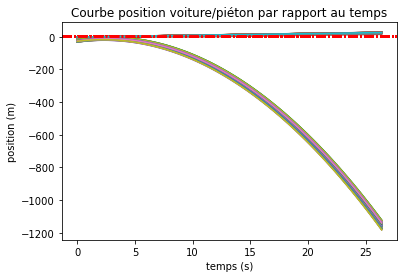

In [25]:
#Positions des agents
t=0
plt.title("Courbe position voiture/piéton par rapport au temps")
plt.xlabel("temps (s)")
plt.ylabel("position (m)")
while t+1<len(ep_time):
    t_init=t
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        t+=1
    plt.plot(ep_time[t_init:t],ep_pos_car[t_init:t])
    plt.plot(ep_time[t_init:t],ep_pos_ped[t_init:t])
    plt.axhline(y=5, color='r', linestyle='-.')
    plt.axhline(y=0, color='r', linestyle='-.')
    t+=1
_=plt.axhline(y=5, color='r', linestyle='-.')
_=plt.axhline(y=0, color='r', linestyle='-.')

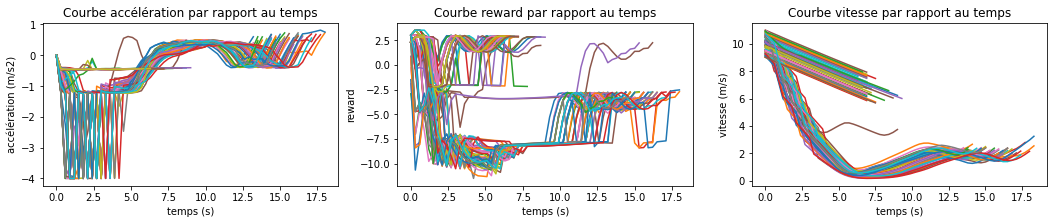

In [11]:
#Accélération, Reward, Vitesse de la voiture
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(18, 3))

t=0
ax1.set_title("Courbe accélération par rapport au temps")
ax1.set_xlabel("temps (s)")
ax1.set_ylabel("accélération (m/s2)")

ax2.set_title("Courbe reward par rapport au temps")
ax2.set_xlabel("temps (s)")
ax2.set_ylabel("reward")

ax3.set_title("Courbe vitesse par rapport au temps")
ax3.set_xlabel("temps (s)")
ax3.set_ylabel("vitesse (m/s)")
while t+1<len(ep_time):
    t_init=t
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        t+=1
    ax1.plot(ep_time[t_init:t],ep_action[t_init:t])
    ax2.plot(ep_time[t_init:t],ep_reward[t_init:t])
    ax3.plot(ep_time[t_init:t+1],ep_speed_car[t_init:t+1])
    t+=1


In [27]:
t=0
cross_speed=[]
wait_speed=[]
cross_acc=[]
wait_acc=[]

while t+1<len(ep_time):
    t_init=t
    choice=False
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        choice=choice+(ep_speed_car[t]<2.0)
        t+=1
    if(choice):
        cross_speed.append(np.array(ep_speed_car[t_init:t_init+37]))
        cross_acc.append(np.array(states[t_init:t_init+37,0]))
    else:
        wait_speed.append(np.array(ep_speed_car[t_init:t_init+17]))
        wait_acc.append(np.array(states[t_init:t_init+17,0]))
    t+=1
cross_speed=np.array(cross_speed)
wait_speed=np.array(wait_speed)
cross_acc=np.array(cross_acc)
wait_acc=np.array(wait_acc)

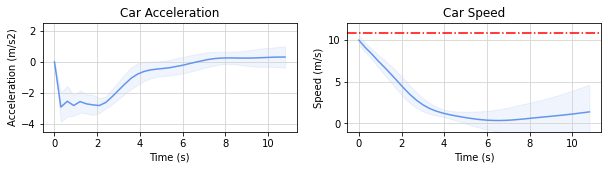

In [28]:
x1=[0.3*i for i in range(37)]
mean_speed=np.mean(cross_speed,axis=0)
std_speed=np.std(cross_speed,axis=0)
mean_acc=np.mean(cross_acc,axis=0)
std_acc=np.std(cross_acc,axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 2))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.set_ylim(-4.5,2.5)
ax1.plot(x1,mean_acc,color='cornflowerblue')
ax1.fill_between(x1, (mean_acc-std_acc), (mean_acc+std_acc), color='cornflowerblue', alpha=0.1)
ax1.grid(True,color='lightgrey')

ax2.set_title('Car Speed')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Speed (m/s)")
ax2.set_ylim(-1.0,12.0)
ax2.axhline(y=ep_speed_car[t_init], color='r', linestyle='-.')
ax2.plot(x1,mean_speed,color='cornflowerblue')
ax2.fill_between(x1, (mean_speed-std_speed), (mean_speed+std_speed), color='cornflowerblue', alpha=0.1)

ax2.grid(True,color='lightgrey')
#fig.savefig("car_cross_ddpg3.pdf")

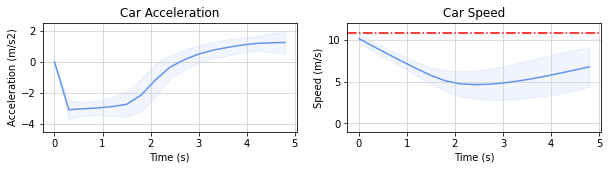

In [29]:
x2=[0.3*i for i in range(17)]

mean_speed2=np.mean(wait_speed,axis=0)
std_speed2=np.std(wait_speed,axis=0)
mean_acc2=np.mean(wait_acc,axis=0)
std_acc2=np.std(wait_acc,axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 2))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.set_ylim(-4.5,2.5)
ax1.plot(x2,mean_acc2,color='cornflowerblue')
ax1.fill_between(x2, (mean_acc2-std_acc2), (mean_acc2+std_acc2), color='cornflowerblue', alpha=0.1)
ax1.grid(True,color='lightgrey')

ax2.set_title('Car Speed')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Speed (m/s)")
ax2.set_ylim(-1.0,12.0)
ax2.axhline(y=ep_speed_car[t_init], color='r', linestyle='-.')
ax2.plot(x2,mean_speed2,color='cornflowerblue')
ax2.fill_between(x2, (mean_speed2-std_speed2), (mean_speed2+std_speed2), color='cornflowerblue', alpha=0.1)
ax2.grid(True,color='lightgrey')
#fig.savefig("car_wait_ddpg3.pdf")

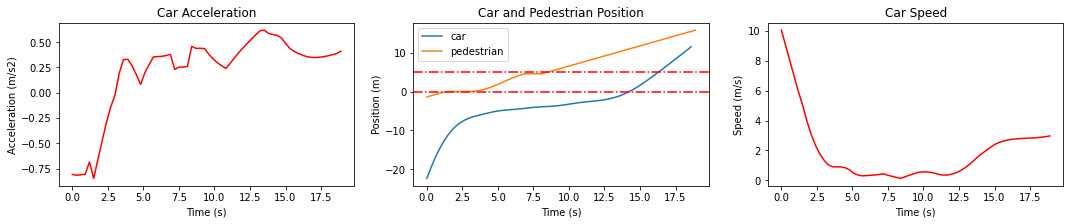

In [35]:
#Résumé du batch de test
#t=0
if (t+1>=len(ep_time)):
    t=0
t_init=t
while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
    t+=1
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(18, 3))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.plot(ep_time[t_init:t+1],actions[t_init:t+1,0],color='r')
#ax2.plot(ep_time[t_init:t+1],states[t_init:t+1,0],color='b')

ax2.set_title('Car and Pedestrian Position')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Position (m)")
ax2.plot(ep_time[t_init:t],ep_pos_car[t_init:t],label='car')
ax2.plot(ep_time[t_init:t+1],ep_pos_ped[t_init:t+1],label='pedestrian')
ax2.axhline(y=5, color='r', linestyle='-.')
ax2.axhline(y=0, color='r', linestyle='-.')
ax2.legend()

ax3.set_title('Car Speed')
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Speed (m/s)")
ax3.plot(ep_time[t_init:t+1],ep_speed_car[t_init:t+1],color='r')

t+=1

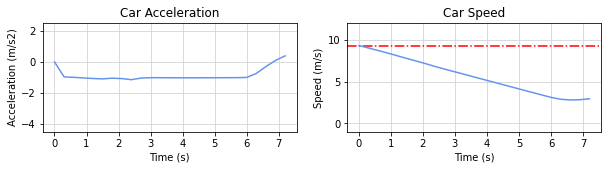

In [66]:
t-=1
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 2))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.set_ylim(-4.5,2.5)
ax1.plot(ep_time[t_init:t+1],states[t_init:t+1,0],color='cornflowerblue')
ax1.grid(True,color='lightgrey')

ax2.set_title('Car Speed')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Speed (m/s)")
ax2.set_ylim(-1.0,12.0)
ax2.axhline(y=ep_speed_car[t_init], color='r', linestyle='-.')
ax2.plot(ep_time[t_init:t+1],ep_speed_car[t_init:t+1],color='cornflowerblue')
ax2.grid(True,color='lightgrey')
fig.savefig("car_cross_ddpg.pdf")
t+=1

In [ ]:
#plt.fill_between(x, (y-ci), (y+ci), color='blue', alpha=0.1)